In [1]:
from mapper_base import MapperBase
from astropy.io import fits
from astropy.table import Table

import mapper_DESgc
import pyccl as ccl
import numpy as np
import pylab as plt
import pymaster as nmt
import healpy as hp
import os

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
# Initialize binning scheme with 20 ells per bandpower
nside = 1024
ells = []
i = 11.5
while i <= 3 * nside:
    ells.append(round(i))
    #i = i*(1+i/(3 * nside))
    i = i+20*(1+i/240)

bands = nmt.NmtBin.from_edges(ells[:-1], ells[1:])
ell_arr = bands.get_effective_ells()

In [3]:
DES_1_config = {'data_catalogs':'/home/zcapjru/PhD/Data/DES_redm/DES_Y1A1_3x2pt_redMaGiC_zerr_CATALOG.fits', 
                'file_mask':'/home/zcapjru/PhD/Data/DES_redm/DES_Y1A1_3x2pt_redMaGiC_MASK_HPIX4096RING.fits',
                'file_nz':'/home/zcapjru/PhD/Data/DES_redm/2pt_NG_mcal_1110.fits',
          'bin':1,
          'nside':nside, 
          'mask_name': 'mask_DESgc_1'}

DES_2_config = {'data_catalogs':'/home/zcapjru/PhD/Data/DES_redm/DES_Y1A1_3x2pt_redMaGiC_zerr_CATALOG.fits', 
                'file_mask':'/home/zcapjru/PhD/Data/DES_redm/DES_Y1A1_3x2pt_redMaGiC_MASK_HPIX4096RING.fits',
                'file_nz':'/home/zcapjru/PhD/Data/DES_redm/2pt_NG_mcal_1110.fits',
          'bin':2,
           'mask_name': 'mask_DESgc_2',
          'nside':nside }

In [4]:
DES_1_maps = mapper_DESgc.MapperDESgc(DES_1_config)
DES_2_maps = mapper_DESgc.MapperDESgc(DES_2_config)

/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(


In [5]:
DES_nz_1 = DES_1_maps.get_nz()
DES_z_1 = DES_nz_1[0]
DES_dNdz_1 = DES_nz_1[1]

DES_nz_2 = DES_2_maps.get_nz()
DES_z_2 = DES_nz_2[0]
DES_dNdz_2 = DES_nz_2[1]

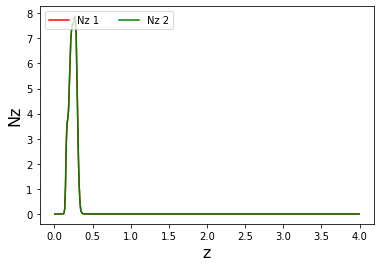

In [6]:
plt.plot(DES_z_1, DES_dNdz_1, 'r-', label='Nz 1')
plt.plot(DES_z_1, DES_dNdz_1, 'g-', label='Nz 2')

plt.xlabel('z', fontsize=16)
plt.ylabel('Nz', fontsize=16)
plt.legend(loc='upper left', ncol=2, labelspacing=0.1)
plt.show()

In [7]:
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.049, h=0.67, sigma8=0.81, n_s=0.96)
biases = {
    'b1': 1.41,
    'b2': 1.60,
    'b3': 1.60,
    'b4': 1.91,
    'b5': 1.96 
}

b1 = biases['b1']*np.ones(len(DES_z_1))
DES_gc1 = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(DES_z_1,DES_dNdz_1), bias=(DES_z_1,b1))
b2 = biases['b2']*np.ones(len(DES_z_2))
DES_gc2 = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(DES_z_2,DES_dNdz_2), bias=(DES_z_2,b2))

In [8]:
DES_theory_11 = ccl.angular_cl(cosmo, DES_gc1, DES_gc1, ell_arr) 
DES_theory_12 = ccl.angular_cl(cosmo, DES_gc1, DES_gc2, ell_arr) 

In [ ]:
# Read healpix maps and initialize a spin-0 and spin-2 field
DES_mask_1  = DES_1_maps.get_mask()
DES_signal_1 = DES_1_maps.get_signal_map()
DES_mask_2  = DES_2_maps.get_mask()
DES_signal_2 = DES_2_maps.get_signal_map()

In [ ]:
hp.visufunc.mollview(DES_signal_1[0], title= 'DES gc')

In [ ]:
hp.visufunc.mollview(DES_mask_1, title= 'Mask')


In [ ]:
DES_f_1 =  DES_1_maps.get_nmt_field()
DES_f_2 =  DES_2_maps.get_nmt_field()

In [ ]:
DES_w_11 = nmt.NmtWorkspace()
DES_w_11.compute_coupling_matrix(DES_f_1, DES_f_1, bands)

DES_w_12 = nmt.NmtWorkspace()
DES_w_12.compute_coupling_matrix(DES_f_1, DES_f_2, bands)

In [ ]:
def compute_cl(f_a, f_b, wsp):
    # Compute the power spectrum (a la anafast) of the masked fields
    # Note that we only use n_iter=0 here to speed up the computation,
    # but the default value of 3 is recommended in general.
    cl_coupled = nmt.compute_coupled_cell(f_a, f_b)
    # Decouple power spectrum into bandpowers inverting the coupling matrix
    cl_decoupled = wsp.decouple_cell(cl_coupled) #removed bias here

    return cl_decoupled

In [ ]:
def load_carlos_cl(a, b):
    return np.load('/home/zcapjru/PhD/Data/DESgc_carlos/cl_DESgc{}_DESgc{}.npz'.format(a,b))

In [ ]:
DES_nl_11 = DES_w_11.decouple_cell(DES_1_maps.get_nl_coupled())
cl_11 = compute_cl(DES_f_1, DES_f_1, DES_w_11)
cl_11 = cl_11 - DES_nl_11
ccl_11 = load_carlos_cl(0,0)

In [ ]:
cl_12 = compute_cl(DES_f_1, DES_f_2, DES_w_12)
ccl_12 = load_carlos_cl(0,1)

In [ ]:
plt.plot(ell_arr, cl_11[0], 'r-', label='Jaime cl_ij')
plt.plot(ell_arr, DES_theory_11, 'r--', label='Theory cl_ij')
plt.plot(ccl_11['ell'], ccl_11['cl'][0], 'g-', label='Carlos cl_ij')

plt.loglog()
plt.title('DES gc Cl 11')
plt.xlim((ell_arr[1], ell_arr[-1]))
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()

In [ ]:
plt.plot(ell_arr, cl_12[0], 'r-', label='Jaime cl_ij')
plt.plot(ell_arr, DES_theory_12, 'r--', label='Theory cl_ij')
plt.plot(ccl_11['ell'], ccl_12['cl'][0], 'g-', label='Carlos cl_ij')

plt.loglog()
plt.title('DES gc Cl 12')
plt.xlim((ell_arr[1], ell_arr[-1]))
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()

## Checking with Carlos 

In [ ]:
def load_cl(a, b):
    return np.loadtxt('/home/zcapjru/PhD/Data/get_4096/DES_cl_{}{}.txt'.format(a,b))

In [ ]:
nside = 4096

ells = []
i = 11.5
while i <= 3 * nside:
    ells.append(round(i))
    i = i+20*(1+i/500)
bands = nmt.NmtBin.from_edges(ells[:-1], ells[1:])
ell_arr = bands.get_effective_ells()

In [ ]:
cl_11 = load_cl(0,0)
cl_12 = load_cl(0,1)
ccl_11 = load_carlos_cl(0,0)
ccl_12 = load_carlos_cl(0,1)


In [ ]:
print(ccl_11['ell'], ccl_11['cl'])
print(cl_11)

In [ ]:
#plt.plot( cl_11, 'r-', label='Jaime cl_ij')
plt.plot(ccl_11['ell'], ccl_11['cl'][0], 'g-', label='Carlos cl_ij')

plt.loglog()
plt.title('Quasars density angular power spectrum')
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()